In [ ]:
! pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

! cp /content/drive/MyDrive/kaggle.json ~/
! mkdir ~/.kaggle
! mv ~/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [ ]:
! kaggle datasets download -d eldarsultanow/ml-bsd-dataset

 99% 1.50G/1.51G [00:25<00:00, 93.2MB/s]
100% 1.51G/1.51G [00:25<00:00, 63.9MB/s]


In [ ]:
! unzip ml-bsd-dataset.zip

Archive:  ml-bsd-dataset.zip
  inflating: rank-vs-ap.csv          


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [ ]:
def mestre_nagao_classifier(ap_values):
    diffs = np.abs(ap_values[:, 1:] - ap_values[:, :-1])
    sums = np.sum(diffs, axis=1)

    median_sum = np.median(sums)
    std_sum = np.std(sums)

    binary_mask = np.zeros((len(ap_values),))
    for i in range(len(ap_values)):
        if sums[i] > median_sum + std_sum:
            binary_mask[i] = 1
    return binary_mask

In [ ]:
df = pd.read_csv('rank-vs-ap.csv')


In [ ]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [ ]:
ap_cols = [f"ap_{i}" for i in range(1, 30)]
X = df[ap_cols].values
y = df['rank'].astype('category').cat.codes.values

In [ ]:
rank_values = df['rank'].values


In [ ]:
binary_mask = mestre_nagao_classifier(X)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, binary_mask, test_size=0.2, stratify=binary_mask)

In [ ]:
num_timesteps = X.shape[1]
x_train = x_train.reshape(x_train.shape[0], num_timesteps, 1)
x_val = x_val.reshape(x_val.shape[0], num_timesteps, 1)

In [ ]:
model = models.Sequential()
model.add(layers.Conv1D(32, 3, activation='relu', input_shape=x_train.shape[1:]))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))


Epoch 1/10
3750/3750 [==============================] - 15s 3ms/step - loss: 0.1610 - accuracy: 0.9326 - val_loss: 0.1269 - val_accuracy: 0.9427
Epoch 2/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.1086 - accuracy: 0.9524 - val_loss: 0.1732 - val_accuracy: 0.9307
Epoch 3/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.1053 - accuracy: 0.9538 - val_loss: 0.1000 - val_accuracy: 0.9558
Epoch 4/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.1035 - accuracy: 0.9547 - val_loss: 0.0921 - val_accuracy: 0.9595
Epoch 5/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.1005 - accuracy: 0.9556 - val_loss: 0.1033 - val_accuracy: 0.9543
Epoch 6/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.0973 - accuracy: 0.9568 - val_loss: 0.0911 - val_accuracy: 0.9612
Epoch 7/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.0974 - accuracy: 0.9572 - val_loss: 0.0930 - val_ac

In [ ]:
test_loss, test_accuracy = model.evaluate(x_val, y_val, verbose=0)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

Test loss: 0.10408944636583328, Test accuracy: 0.9545317888259888


In [ ]:
rank_predictions = model.predict(X).flatten()

4688/4688 [==============================] - 8s 2ms/step


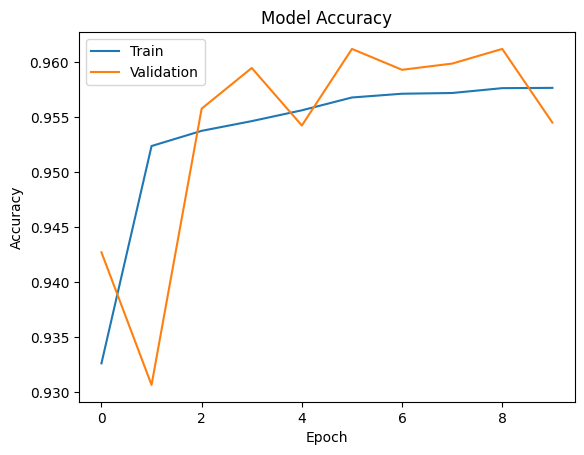

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

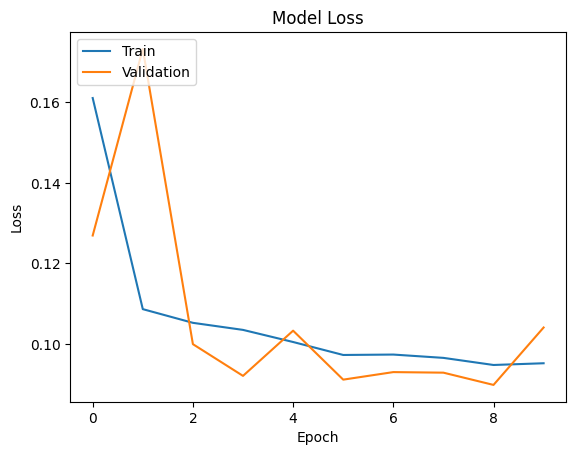

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Text(0, 0.5, 'Predicted Rank')

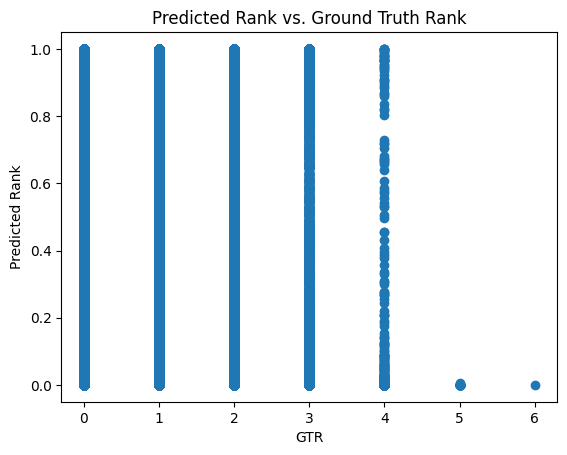

In [ ]:
plt.scatter(rank_values, rank_predictions)
plt.title('Predicted Rank vs. Ground Truth Rank')
plt.xlabel('GTR')
plt.ylabel('Predicted Rank')